<a href="https://colab.research.google.com/github/mohamed-habib-jaberi/Deep-Learning/blob/main/CrisisTweetAI_Classifying_Real_Disaster_Tweets_Using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bf4f492a-37c5-86fd-6a0b-73033d369542)


**Creating helper functions**

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/refs/heads/main/Computer%20Vision%20and%20CNN%20in%20TensorFlow/helper_functions.py


--2025-10-26 19:59:14--  https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/refs/heads/main/Computer%20Vision%20and%20CNN%20in%20TensorFlow/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10245 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2025-10-26 19:59:14 (116 MB/s) - ‘helper_functions.py.2’ saved [10245/10245]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

**📘 Downloading the Dataset**

We’ll start by downloading a text dataset from Kaggle — the “Real or Not?” Disaster Tweets dataset.
It contains Tweets labeled as either real (about actual disasters) or not real (unrelated tweets).

Examples:

*   ✅ Real Tweet:
“Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano.”

*   ❌ Not Real Tweet:
“‘Education is the most powerful weapon which you can use to change the world.’ — Nelson Mandela #quote”

In [4]:
# Download data
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2025-10-26 19:59:22--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.2’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.008s  

2025-10-26 19:59:22 (74.9 MB/s) - ‘nlp_getting_started.zip.2’ saved [607343/607343]



**Visualizing a text dataset**

In [5]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The training data we downloaded is probably shuffled already. But just to be sure, let's shuffle it again.

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

,count
target,
0,4342
1,3271


Since we have two target values, we're dealing with a binary classification problem.

It's fairly balanced too, about 60% negative class `(target = 0)` and 40% positive class `(target = 1)`.

Where,

*   1 = a real disaster Tweet
*   0 = not a real disaster Tweet

And what about the total number of samples we have?

In [9]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


Alright, seems like we've got a decent amount of training and test data. If anything, we've got an abundance of testing examples, usually a split of 90/10 (90% training, 10% testing) or 80/20 is suffice.



In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Literally trapped in my room Cuz my bathroom being remodeled. The only exit is through a window

---

Target: 1 (real disaster)
Text:
@NBCNews Yea bombing #pearlharbor not so good of an idea!

---

Target: 1 (real disaster)
Text:
Ebola: Alabama Home Quarantined Over Possible Ebola Case.. Related Articles: http://t.co/BiigD1LEq3

---

Target: 0 (not real disaster)
Text:
'Without an ally near you can't use this skill.' How did you get hired? Really cause it's making every Riot staff member look incompetent.

---

Target: 0 (not real disaster)
Text:
The tragedy of life is not that it ends so soon but that we wait so long to begin it. ~ W.M. Lewis #quotes

---



**Split data into training and validation sets**

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's train_test_split() method and dedicate 10% of the training samples to the validation set.


In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility


In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(6851, 6851, 762, 762)

In [13]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

**Text vectorization (tokenization)**

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

**🔧 Customizing the TextVectorization Layer**

We’ve initialized a TextVectorization layer with the default settings — now, let’s customize it for our specific task.

In particular, we’ll define values for:

*   max_tokens → the maximum size of the vocabulary (number of unique words to keep).
Common choices are multiples of 10,000 (e.g., 10,000, 20,000, 30,000) or the exact number of unique words in the dataset.
👉 For this project, we’ll use 10,000.
*   output_sequence_length → the length of each text sequence after tokenization.
We’ll set it to the average number of tokens per Tweet in the training set — but first, we need to compute that value.


In [15]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

Now let's create another TextVectorization object using our custom parameters.

In [16]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

To map our TextVectorization instance text_vectorizer to our data, we can call the adapt() method on it whilst passing it our training text

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

Training data mapped! Let's try our text_vectorizer on a custom sentence (one similar to what you might see in the training data).

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

We can now turn our text into numbers using word-level tokenization.
The zeros (0’s) at the end of the output appear because we set output_sequence_length=15.
This makes sure every sequence has exactly 15 tokens, no matter how short or long the original text is.

How about we try our text_vectorizer on a few random sentences?

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Accident on I-24 W #NashvilleTraffic. Traffic moving 8m slower than usual. https://t.co/0GHk693EgJ      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 128,   11,    1,  308,    1,  592, 1386,    1, 3404,   76, 2238,
           1,    0,    0,    0]])>

Finally, we can check the unique tokens in our vocabulary using the get_vocabulary() method.

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
Bottom 5 least common words: [np.str_('pages'), np.str_('paeds'), np.str_('pads'), np.str_('padres'), np.str_('paddytomlinson1')]


**Creating an Embedding using an Embedding Layer**

Now that we can turn text into numbers, let’s go one step further and create embeddings.

An embedding is special because it can be learned and improved during training — meaning a word’s numeric representation isn’t fixed.
For example, instead of always being 1 = I, 2 = love, 3 = TensorFlow, the model can adjust these values as it learns from the data.

In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

Great! Notice that our embedding is a TensorFlow layer — this means we can include it directly in our model.
Because it’s part of the model, its parameters (the word representations) can be updated and improved as the model learns during training.

How about we try it out on a sample sentence?


In [22]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Obama Declares Disaster for Typhoon-Devastated Saipan:  http://t.co/M6LvKXl9ii      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02989227,  0.03935653, -0.02601082, ..., -0.00746787,
          0.00934546,  0.04308314],
        [-0.04410151, -0.00873427,  0.0310434 , ..., -0.04152421,
          0.00790987, -0.00791653],
        [-0.04229007,  0.00133521, -0.04984492, ...,  0.0164613 ,
          0.01455939,  0.01191897],
        ...,
        [-0.00547497, -0.02779227,  0.00441773, ...,  0.04145397,
         -0.03134415, -0.00600543],
        [-0.00547497, -0.02779227,  0.00441773, ...,  0.04145397,
         -0.03134415, -0.00600543],
        [-0.00547497, -0.02779227,  0.00441773, ...,  0.04145397,
         -0.03134415, -0.00600543]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.02989227,  0.03935653, -0.02601082,  0.004537  , -0.02148856,
        0.03069551,  0.01778791, -0.00392558, -0.02837468, -0.02915227,
       -0.02825858,  0.00230528,  0.04929898,  0.02875182,  0.00055792,
       -0.03365231,  0.01094859,  0.01423353,  0.02434957, -0.03737258,
       -0.02998197, -0.03270835,  0.0150653 , -0.01897889, -0.02165011,
       -0.04041968,  0.00107436,  0.02615089,  0.01302623,  0.00271649,
       -0.00018872, -0.01344611,  0.0213634 , -0.03736462, -0.00563771,
        0.04663109, -0.00917013, -0.0274109 , -0.0083055 , -0.00970881,
       -0.00680333,  0.02879217,  0.0307515 ,  0.01757595, -0.03983625,
        0.03928402, -0.00646862, -0.02540823,  0.01074784,  0.04660794,
       -0.02417672, -0.00440864,  0.01319698, -0.0399139 ,  0.03111377,
        0.00545783,  0.00961997, -0.03220072, -0.03449205,  0.01075275,
       -0.04517874, -0.02639659,  0.03108125,  0.02249387, -0.0165174 ,
       -0.009711

# Modelling a text dataset

🧩 Building Models from Text Data

Once the inputs and outputs are ready, the next step is to choose a machine learning model that connects them.

Now that we can convert our text data into numbers, we can start building and training different models to learn from it.

To get hands-on experience, we’ll create a series of models, treating each one as a separate experiment.
Afterward, we’ll compare their results to see which performs best.

More specifically, we'll be building the following:

*   **Model 0:** Naive Bayes (baseline)
*   **Model 1:** Feed-forward neural network (dense model)
*   **Model 2:** LSTM model
*   **Model 3:** GRU model
*   **Model 4:** Bidirectional-LSTM model
*   **Model 5:** 1D Convolutional Neural Network
*   **Model 6:** TensorFlow Hub Pretrained Feature Extractor
*   **Model 7:** Same as model 6 with 10% of training data

Our **Model 0** will be the simplest one — it serves as a **baseline** that we expect the deeper and more complex models to outperform.

Each experiment will follow these main steps:

*   Construct the model
*   Train the model
*   Make predictions with the model
*   Track prediction evaluation metrics for later comparison

# Model 0: Getting a baseline

As with any machine learning experiment, it’s important to start with a baseline model — a simple reference point to compare future results against.

For our baseline, we’ll build a Scikit-Learn Pipeline that uses TF-IDF (Term Frequency–Inverse Document Frequency) to convert text into numeric features, and then apply the Multinomial Naive Bayes algorithm for classification.

https://scikit-learn.org/stable/machine_learning_map.html

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

Let's evaluate our model and find our baseline metric.

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


How about we make some predictions with our baseline model?

In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

**Creating an evaluation function for our model experiments**

We could evaluate our models directly, but since we’ll be testing multiple models in the same way, it’s better to create a helper function.
This function will take the model’s predictions and the true labels, then calculate key evaluation metrics.

*   Accuracy
*   Precision
*   Recall
*   F1-score

In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Model 1: A simple dense model


Our first deep learning model will be a very simple one — a single dense layer.

Here’s what it will do step by step:

	1.	Take the input text and labels.
	2.	Tokenize the text.
	3.	Create an embedding for each token.
	4.	Compute the average of those embeddings using Global Average Pooling.
	5.	Pass the result through a fully connected (Dense) layer with one output
  unit and a sigmoid activation to produce the final prediction.

It might sound like a lot, but everything will become clear once we start coding — when in doubt, code it out! 💻

Since we’ll be building several TensorFlow models, we’ll also import the create_tensorboard_callback() function from helper_functions.py to help track and compare their results.

In [29]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

**Let's build our first deep model.**

In [30]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

🧩 Step-by-Step Explanation

	1.	inputs = layers.Input(shape=(1,), dtype="string")
	  •	Defines the input layer that expects 1-dimensional text strings.
	  •	Each input sample is a single sentence or tweet.

	2.	x = text_vectorizer(inputs)
	  •	Converts the input text into numeric token sequences using the TextVectorization layer you defined earlier.
	  •	This step transforms raw text into integers that represent words.

	3.	x = embedding(x)
	  •	Maps each integer (token) to a dense embedding vector.
	  •	The embedding layer learns meaningful representations of words during training.

	4.	x = layers.GlobalAveragePooling1D()(x)
	  •	Reduces each sequence of embeddings to a single vector by averaging across all tokens.
	  •	This gives a fixed-size representation for variable-length text inputs.
	  •	(You can experiment by removing this layer to see how it affects model size and performance.)

	5.	outputs = layers.Dense(1, activation="sigmoid")(x)
	  •	Adds a Dense (fully connected) output layer with one neuron and a sigmoid activation.
	  •	Because it’s a binary classification task (disaster vs. not disaster), the output value will be between 0 and 1.

	6.	model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")
	  •	Assembles the model using the Functional API — connecting inputs to outputs.
	  •	The resulting model (model_1) is ready to be compiled and trained.


**✅ In summary:**
**Text → Vectorized → Embedded → Averaged → Passed through Dense layer → Output = probability of “disaster”.**

we can fit our model to the data, we've got to compile it. Since we're working with binary classification, we'll use `"binary_crossentropy"` as our loss function and the Adam optimizer.

In [31]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Model compiled. Let's get a summary.

In [32]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Our model is compiled, let's fit it to our training data for 5 epochs. We'll also pass our TensorBoard callback function to make sure our model's training metrics are logged.

In [33]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])


Saving TensorBoard log files to: model_logs/simple_dense_model/20251026-195929
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6324 - loss: 0.6510 - val_accuracy: 0.7585 - val_loss: 0.5349
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8071 - loss: 0.4678 - val_accuracy: 0.7900 - val_loss: 0.4740
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8517 - loss: 0.3635 - val_accuracy: 0.7966 - val_loss: 0.4616
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8868 - loss: 0.2972 - val_accuracy: 0.7874 - val_loss: 0.4674
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9057 - loss: 0.2484 - val_accuracy: 0.7795 - val_loss: 0.4828


Let's check our model's performance on the validation set.

In [34]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7680 - loss: 0.5153


[0.48284751176834106, 0.7795275449752808]

In [35]:
embedding.weights

[<Variable path=embedding_1/embeddings, shape=(10000, 128), dtype=float32, value=[[ 0.00379647 -0.01251456 -0.00918469 ...  0.03235684 -0.04573125
   -0.01866648]
  [ 0.00476014  0.00290951 -0.04061356 ... -0.02772764 -0.02108557
   -0.00701953]
  [ 0.03085653 -0.0099832  -0.05111827 ...  0.02810591 -0.0374011
   -0.02074027]
  ...
  [-0.01771443 -0.01998739 -0.03577502 ... -0.01259333  0.04670614
   -0.02471961]
  [ 0.02433892 -0.00100098 -0.04025646 ...  0.00776145 -0.02824663
   -0.02301542]
  [ 0.05099222  0.01986061 -0.02554238 ... -0.03846777 -0.09641965
   -0.07051097]]>]

We've built and trained our first deep model, the next step is to make some predictions with it.

In [36]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[0.33003917],
       [0.7336748 ],
       [0.99759644],
       [0.18432404],
       [0.10078084],
       [0.94231564],
       [0.8948558 ],
       [0.9943394 ],
       [0.96132505],
       [0.38219205]], dtype=float32)

In [37]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Now we've got our model's predictions in the form of classes, we can use our calculate_results()` function to compare them to the ground `truth validation labels.

In [38]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.95275590551181,
 'precision': 0.7825962002002497,
 'recall': 0.7795275590551181,
 'f1': 0.7770045099502749}

In [39]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

How about we compare our first deep model to our baseline model?

In [40]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))


array([False, False, False, False])

Since we'll be doing this kind of comparison (baseline compared to new model) quite a few times, let's create a function to help us out.

In [41]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


**Visualizing learned embeddings**

In [42]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000,
 ['',
  '[UNK]',
  np.str_('the'),
  np.str_('a'),
  np.str_('in'),
  np.str_('to'),
  np.str_('of'),
  np.str_('and'),
  np.str_('i'),
  np.str_('is')])

In [43]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [44]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)


(10000, 128)


# Recurrent Neural Networks (RNN's)

When you come across RNN's in the wild, you'll most likely come across variants of the following:

*   Long short-term memory cells (LSTMs).
*   Gated recurrent units (GRUs).
*   Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

# Model 2: LSTM



We’ll start by building an RNN using LSTM (Long Short-Term Memory) — a special type of RNN that can remember information over longer sequences.

In TensorFlow, we can use the tensorflow.keras.layers.LSTM() layer to create an LSTM-based model.
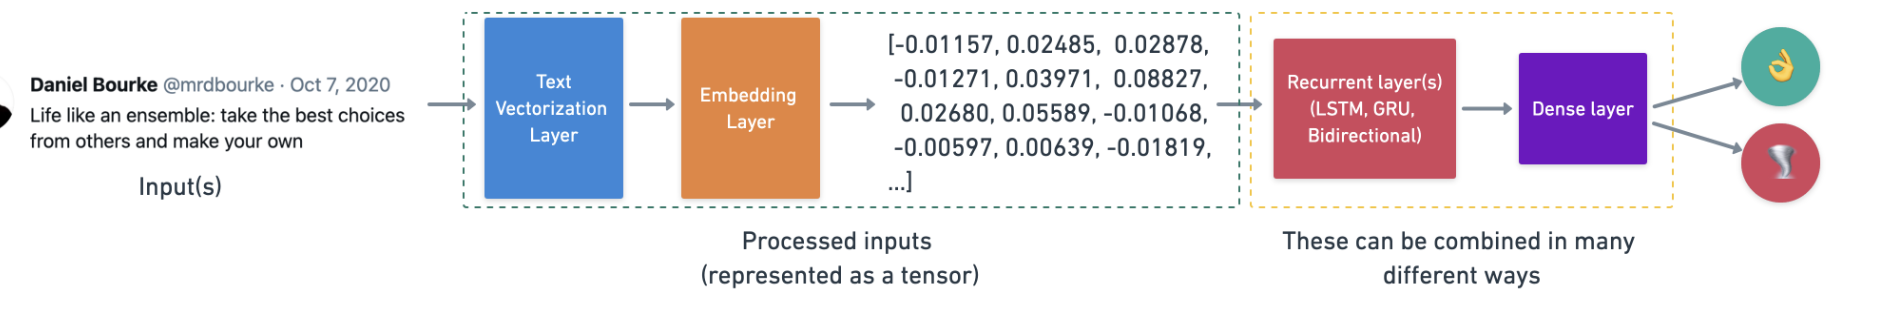

Just like in Model 1, our new model will follow the same overall structure:

**Input (text) → Tokenization → Embedding → Layers → Output (label probability)**

The main difference is that we’ll add an LSTM layer between the embedding and the output to help the model better capture the sequence and context of the words.

To ensure a fair comparison between models, we’ll create a new embedding layer (model_2_embedding) so we’re not reusing previously trained embeddings.
However, we can safely reuse the text_vectorizer layer, since it doesn’t learn or update during training.

In [45]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


let's compile it using "binary_crossentropy" loss and the Adam optimizer.

In [46]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

And before we fit our model to the data, let's get a summary.

In [47]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Looking good! we'll notice a fair few more trainable parameters within our LSTM layer than model_1.

Now our first RNN model's compiled let's fit it to our training data, validating it on the validation data and tracking its training parameters using our TensorBoard callback.

In [48]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20251026-195942
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6737 - loss: 0.5831 - val_accuracy: 0.7730 - val_loss: 0.4616
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8629 - loss: 0.3327 - val_accuracy: 0.7559 - val_loss: 0.5077
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9134 - loss: 0.2288 - val_accuracy: 0.7559 - val_loss: 0.5804
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9427 - loss: 0.1611 - val_accuracy: 0.7441 - val_loss: 0.7350
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9613 - loss: 0.1152 - val_accuracy: 0.7585 - val_loss: 0.7387


In [49]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


((762, 1),
 array([[0.01017245],
        [0.8053812 ],
        [0.9995136 ],
        [0.05741305],
        [0.0067196 ],
        [0.99925286],
        [0.49539834],
        [0.9997104 ],
        [0.9988913 ],
        [0.27437508]], dtype=float32))

We can turn these prediction probabilities into prediction classes by rounding to the nearest integer (by default, prediction probabilities under 0.5 will go to 0 and those over 0.5 will go to 1).

In [50]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

Beautiful, now let's use our `caculate_results()` function to evaluate our LSTM model and our compare_baseline_to_new_results(`)` function to compare it to our baseline model.

In [51]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.8530183727034,
 'precision': 0.7598294832351254,
 'recall': 0.7585301837270341,
 'f1': 0.7563403360005101}

In [52]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.85, Difference: -3.41
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


# Model 3: GRU

The GRU (Gated Recurrent Unit) works similarly to an LSTM, but it’s more lightweight and has fewer parameters, making it faster to train.

In TensorFlow, we can create a GRU layer using tensorflow.keras.layers.GRU().

Our GRU model will follow the same structure as before:

**Input (text) → Tokenization → Embedding → Layers → Output (label probability)**

The only change is that we’ll replace the LSTM layer with a GRU layer between the embedding and the output.

In [53]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

TensorFlow makes it easy to use powerful components such as the GRU cell in our models. And now our third model is built, let's compile it, just as before.

In [54]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

What does a summary of our model look like?

In [55]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

Notice that Model 3 (GRU) has fewer trainable parameters than Model 2 (LSTM).
This is because GRU cells are designed to be simpler and more efficient, using fewer parameters than LSTMs.

Next, we’ll train our GRU model just like the previous ones and track its performance using the `create_tensorboard_callback()` function.

In [56]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])


Saving TensorBoard log files to: model_logs/GRU/20251026-195954
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6382 - loss: 0.6105 - val_accuracy: 0.7769 - val_loss: 0.4614
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8583 - loss: 0.3413 - val_accuracy: 0.7690 - val_loss: 0.5202
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9118 - loss: 0.2356 - val_accuracy: 0.7717 - val_loss: 0.5693
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9398 - loss: 0.1691 - val_accuracy: 0.7651 - val_loss: 0.5969
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9608 - loss: 0.1286 - val_accuracy: 0.7703 - val_loss: 0.6560


In [57]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


((762, 1),
 array([[0.11601779],
        [0.9092161 ],
        [0.9955586 ],
        [0.13980535],
        [0.01237329],
        [0.9930843 ],
        [0.62875587],
        [0.9982692 ],
        [0.99653995],
        [0.92950016]], dtype=float32))

Again we get an array of prediction probabilities back which we can convert to prediction classes by rounding them.

In [58]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

Now we've got predicted classes, let's evaluate them against the ground truth labels.

In [59]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7715893693867238,
 'recall': 0.7703412073490814,
 'f1': 0.7684486602580174}

In [60]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# Model 4: Bidirectonal RNN model

A standard RNN reads a sequence from left to right, while a bidirectional RNN processes it in both directions — first left to right, then right to left.

This allows the model to understand context from both past and future words in a sentence, often leading to better performance on sequence tasks.

However, this improvement comes with a trade-off: more parameters and longer training times, since the network effectively learns in two directions.

TensorFlow helps us out by providing the `tensorflow.keras.layers.Bidirectional` class. We can use the Bidirectional class to wrap our existing RNNs, instantly making them bidirectional.

In [61]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**🔑 Note: You can use the Bidirectional wrapper on any RNN cell in TensorFlow. For example, layers.Bidirectional(layers.GRU(64)) creates a bidirectional GRU cell.**

In [62]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

And of course, we'll check out a summary.

In [63]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

Notice the increased number of trainable parameters in model_4 (bidirectional LSTM) compared to model_2 (regular LSTM). This is due to the bidirectionality we added to our RNN.

Time to fit our bidirectional model and track its performance.

In [64]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20251026-200004
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6832 - loss: 0.5783 - val_accuracy: 0.7743 - val_loss: 0.4629
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8640 - loss: 0.3278 - val_accuracy: 0.7664 - val_loss: 0.5101
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9136 - loss: 0.2231 - val_accuracy: 0.7612 - val_loss: 0.5963
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9487 - loss: 0.1495 - val_accuracy: 0.7717 - val_loss: 0.6538
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9642 - loss: 0.1122 - val_accuracy: 0.7572 - val_loss: 0.7363


Due to the bidirectionality of our model we see a slight increase in training time.

Let's make some predictions with it.

In [65]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


array([[0.06886984],
       [0.96241564],
       [0.99980694],
       [0.0450425 ],
       [0.00568348],
       [0.99452   ],
       [0.88513553],
       [0.9998802 ],
       [0.9997421 ],
       [0.6146779 ]], dtype=float32)

And we'll convert them to prediction classes and evaluate them against the ground truth labels and baseline model.

In [66]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [67]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.7217847769029,
 'precision': 0.7585989210360964,
 'recall': 0.7572178477690289,
 'f1': 0.7549472494674683}

In [68]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 75.72, Difference: -3.54
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


# Convolutional Neural Networks for Text

🧠 Using CNNs for Text Sequences

While Convolutional Neural Networks (CNNs) are commonly used for image processing, they can also be very effective for text and sequence data.

The key difference lies in the shape of the input:

	 •	 Images are 2D (height × width)
	 •	 Text sequences are 1D (a sequence of words or tokens)

To handle text, we use 1D convolutions, which slide filters over word embeddings instead of image pixels.

A typical CNN workflow for sequence data follows this structure:
**Input (text) → Tokenization → Embedding → Convolutional Layers → Output (class probabilities)**

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a `tensorflow.keras.layers.Conv1D()` layer followed by a `tensorflow.keras.layers.GlobablMaxPool1D()` layer.

**Model 5: Conv1D**

Before building a complete 1D CNN model, let’s first understand how a 1-dimensional convolutional layer (also known as a temporal convolution) works.

We’ll start by creating an embedding for a sample text, then pass it through a Conv1D() layer followed by a GlobalMaxPool1D() layer to see how the sequence is transformed.

In [69]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Take a look at the output shapes after each layer:

	 •	  The embedding layer outputs vectors with the dimensions we defined (input_length=15, output_dim=128).
	 •	  The 1D convolution layer further compresses this representation based on its filter and stride settings.
	 •	  The max pooling layer then reduces it even more by keeping only the most important features.

In short, our text starts as a string and is transformed step by step — from tokenization → embedding → convolution → max pooling — into a feature vector of length 64.

Let’s now visualize how each of these transformations changes the data.

In [70]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.04532682, -0.01982968,  0.00412538, ...,  0.01185585,
          -0.0032452 , -0.035288  ],
         [ 0.03662142,  0.07325424, -0.00212742, ..., -0.09333811,
          -0.00464067, -0.03825659],
         [-0.00087524, -0.01982897,  0.0113296 , ...,  0.0187491 ,
           0.03319163, -0.02095269],
         ...,
         [ 0.00379647, -0.01251456, -0.00918469, ...,  0.03235684,
          -0.04573125, -0.01866648],
         [ 0.00379647, -0.01251456, -0.00918469, ...,  0.03235684,
          -0.04573125, -0.01866648],
         [ 0.00379647, -0.01251456, -0.00918469, ...,  0.03235684,
          -0.04573125, -0.01866648]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.7787948e-02,
          0.0000000e+00, 2.4226367e-02, 4.8691891e-03, 0.0000000e+00,
          0.0000000e+00, 3.9183296e-02, 2.9982341e-02, 0.0000000e+00,
          2.0346990e-02,

Now that we’ve explored the individual components of a CNN for text sequences, let’s combine them to build a complete 1D CNN model.

We’ll then compile it using the same setup as our previous models and view a summary of its architecture.

In [71]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

Awesome! The model looks great — notice that the number of trainable parameters in the 1D convolutional layer is similar to the LSTM layer from Model 2.

Next, we’ll train our 1D CNN on the text data and, as in previous experiments, track its performance using the `create_tensorboard_callback()` function.


In [72]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20251026-200024
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6533 - loss: 0.6295 - val_accuracy: 0.7769 - val_loss: 0.4752
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8457 - loss: 0.3741 - val_accuracy: 0.7756 - val_loss: 0.4804
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9127 - loss: 0.2379 - val_accuracy: 0.7808 - val_loss: 0.5398
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9487 - loss: 0.1526 - val_accuracy: 0.7743 - val_loss: 0.6107
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9660 - loss: 0.1034 - val_accuracy: 0.7730 - val_loss: 0.6660


Great! Thanks to GPU acceleration, our 1D CNN model trains quickly and efficiently.

Now, let’s use it to make predictions on the test data and evaluate the results just like we did with the previous models.

In [73]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[0.6872054 ],
       [0.87185556],
       [0.9996265 ],
       [0.10299004],
       [0.00602999],
       [0.99921966],
       [0.9694782 ],
       [0.99901736],
       [0.9985298 ],
       [0.21942344]], dtype=float32)

In [74]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [75]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.29658792650919,
 'precision': 0.7770640736660165,
 'recall': 0.7729658792650919,
 'f1': 0.7698502254147365}

In [76]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 77.30, Difference: -1.97
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# Using Pretrained Embeddings (transfer learning for NLP)

🧠 Using Pretrained Embeddings

Up to this point, all our deep learning models have used embeddings learned from scratch.

However, a powerful alternative is to use **pretrained embeddings** through **transfer learning** — one of the biggest advantages of deep learning.
This allows us to take knowledge learned by a large model trained on massive datasets and adapt it to our specific task.

In our next model, instead of building our own embedding layer, we’ll replace it with a pretrained embedding to benefit from prior learning.

More specifically, we're going to be using [the Universal Sentence Encoder](https://aclanthology.org/D18-2029.pdf) from [Kaggle](https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redire) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

🔑 Note: TensorFlow Hub offers a wide variety of pretrained text embeddings — each with its own preprocessing requirements. It’s a good idea to try out several options and see which one performs best for your specific task.

# Model 6: TensorFlow Hub Pretrained Sentence Encoder


The key difference between our custom embedding layer and the Universal Sentence Encoder (USE) is the level of representation. While our embedding layer produces word-level embeddings (a 128-dimensional vector for each word), the USE generates sentence-level embeddings — a single 512-dimensional vector that represents the entire sentence.

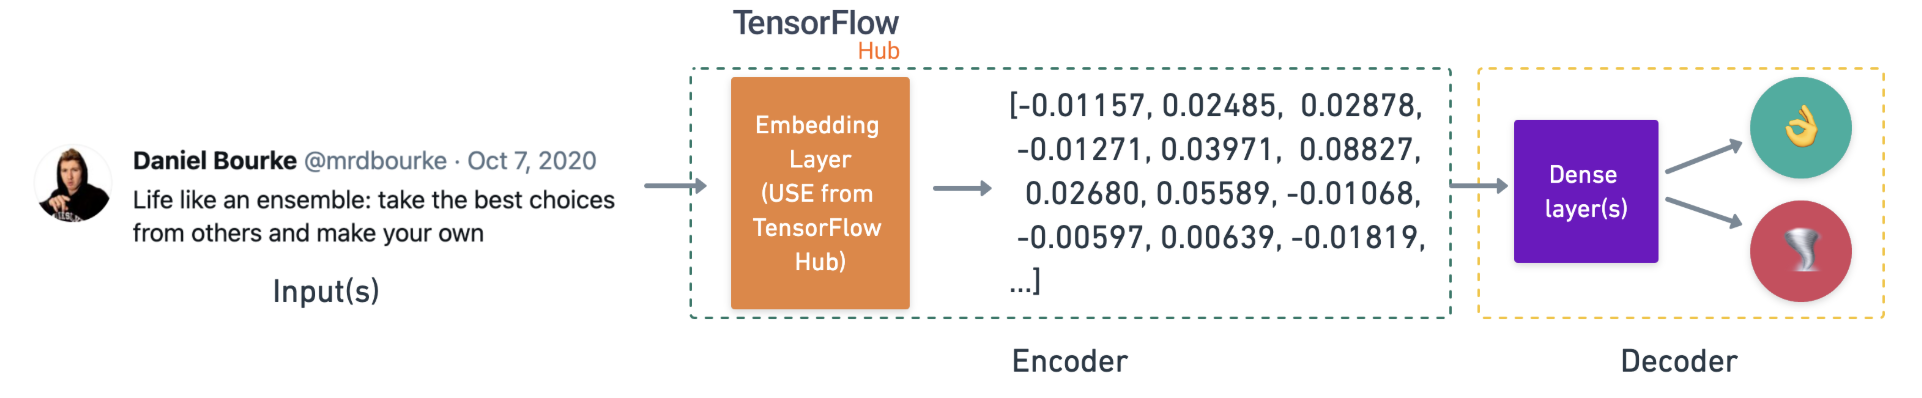

The feature extractor model we're building through the eyes of an encoder/decoder model.

🔑 Note: An encoder is the name for a model which converts raw data such as text into a numerical representation (feature vector), a decoder converts the numerical representation to a desired output.

As always, the best way to understand this is through an example.

We can load a TensorFlow Hub model using the hub.load() method and provide the URL of the module we want — in this case, “https://tfhub.dev/google/universal-sentence-encoder/4”.

Let’s load the Universal Sentence Encoder and try it out on a few sample sentences to see how it works.

In [77]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [78]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

When we pass our sentences through the Universal Sentence Encoder (USE), it transforms them from plain text into 512-dimensional numeric vectors. These numbers might not mean much to us, but they capture the semantic meaning that machine learning models can understand.

Now that we have these embeddings, let’s use them in a model.
We can easily integrate the USE into a Keras model by wrapping it with the hub.KerasLayer class.

In [79]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

Beautiful! Now we've got the USE as a Keras layer, we can use it in a Keras Sequential model

In [80]:
import tensorflow as tf
import tensorflow_hub as hub

# Optional: XLA off avoids string-op issues on GPU (safe to keep)
tf.config.optimizer.set_jit(False)

# ✅ Serializable & registered custom layer
@tf.keras.utils.register_keras_serializable(package="Custom", name="USEEncoder")
class USEEncoder(tf.keras.layers.Layer):
    def __init__(self, handle: str, **kwargs):
        super().__init__(**kwargs)
        self.handle = handle
        # Load once; don't put the loaded object in config
        self._encoder = hub.load(handle)

    def call(self, inputs):
        # Run the TF-Hub graph on CPU (string ops are CPU-friendly)
        with tf.device("/CPU:0"):
            return self._encoder(inputs)

    # ---- Serialization support ----
    def get_config(self):
        config = super().get_config()
        config.update({"handle": self.handle})
        return config

    @classmethod
    def from_config(cls, config):
        # Recreate from the handle
        return cls(**config)

# 🔁 Rebuild model_6 using the serializable layer
inputs = tf.keras.Input(shape=(), dtype=tf.string, name="text")
x = USEEncoder("https://tfhub.dev/google/universal-sentence-encoder/4",
               name="use_embedding")(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_6 = tf.keras.Model(inputs, outputs, name="model_6_USE")
model_6.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"],run_eagerly=True)
model_6.summary()

Model: "model_6_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_embedding (USEEncoder)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20251026-200055
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.7541 - loss: 0.5791 - val_accuracy: 0.7979 - val_loss: 0.4480
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.8024 - loss: 0.4218 - val_accuracy: 0.8110 - val_loss: 0.4377
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.8131 - loss: 0.4073 - val_accuracy: 0.8110 - val_loss: 0.4320
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.8162 - loss: 0.3990 - val_accuracy: 0.8176 - val_loss: 0.4283
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.8193 - loss: 0.3925 - val_accuracy: 0.8189 - val_loss: 0.4257


In [82]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


array([[0.1712482 ],
       [0.8149987 ],
       [0.98994523],
       [0.20604995],
       [0.7659448 ],
       [0.7612745 ],
       [0.98381156],
       [0.9787027 ],
       [0.9592824 ],
       [0.1032231 ]], dtype=float32)

In [83]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8190585128848538,
 'recall': 0.8188976377952756,
 'f1': 0.8182856388893088}

In [85]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.89, Difference: 2.62
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


# Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data


One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [86]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [87]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")


Total training examples: 6851
Length of 10% training examples: 686


Because we've selected a random subset of the training samples, the classes should be roughly balanced (as they are in the full training dataset).

In [88]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

,count
0,415
1,271


To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (model_6) using the `tf.keras.models.clone_model()` method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [89]:
# 🔁 Rebuild model_6 using the serializable layer
inputs = tf.keras.Input(shape=(), dtype=tf.string, name="text")
x = USEEncoder("https://tfhub.dev/google/universal-sentence-encoder/4",
               name="use_embedding")(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_6 = tf.keras.Model(inputs, outputs, name="model_6_USE")

model_6.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_embedding (USEEncoder)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Clone model_6 but reset weights
import tensorflow as tf
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],
                run_eagerly=True )  # keeps string ops safe; remove later if not needed

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_embedding (USEEncoder)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

Notice the layout of model_7 is the same as model_6. Now let's train the newly created model on our 10% training data subset.

In [91]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20251026-200229
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5744 - loss: 0.6850 - val_accuracy: 0.6916 - val_loss: 0.6501
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8239 - loss: 0.6106 - val_accuracy: 0.7415 - val_loss: 0.5893
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.8183 - loss: 0.5308 - val_accuracy: 0.7612 - val_loss: 0.5335
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.8179 - loss: 0.4644 - val_accuracy: 0.7690 - val_loss: 0.5026
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.8214 - loss: 0.4211 - val_accuracy: 0.7743 - val_loss: 0.4886


Due to the smaller amount of training data, training happens even quicker than before.

Let's evaluate our model's performance after learning on 10% of the training data.

In [92]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


array([[0.23030765],
       [0.7773972 ],
       [0.91512233],
       [0.33261767],
       [0.5397089 ],
       [0.81790894],
       [0.8148103 ],
       [0.85956883],
       [0.84278876],
       [0.11157794]], dtype=float32)

In [93]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.42782152230971,
 'precision': 0.7799224267091094,
 'recall': 0.7742782152230971,
 'f1': 0.7706229446239602}

In [95]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.43, Difference: -1.84
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# Comparing the performance of each of our models

Wow — we’ve made incredible progress! 🎉
From building a simple baseline to experimenting with multiple deep learning architectures.

Now it’s time to compare their performances.

Before diving in, it’s worth noting that this kind of experimentation — training several models and comparing their results — is a core part of any deep learning workflow. It helps identify which approach works best and whether further tuning is needed.

Also remember: all models were trained on the same dataset, except for Model 7, which used only 10% of the training data.

Let’s now organize our results into a pandas DataFrame and visualize how each model performed. 📊

In [96]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,77.952756,0.782596,0.779528,0.777005
lstm,75.853018,0.759829,0.758530,0.756340
gru,77.034121,0.771589,0.770341,0.768449
bidirectional,75.721785,0.758599,0.757218,0.754947
conv1d,77.296588,0.777064,0.772966,0.769850
tf_hub_sentence_encoder,81.889764,0.819059,0.818898,0.818286
tf_hub_10_percent_data,77.427822,0.779922,0.774278,0.770623


In [97]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

It looks like our pretrained Universal Sentence Encoder (USE) models achieved the best overall performance — even the version trained with only 10% of the data outperformed all the other models. 💪

This clearly highlights the power of transfer learning — leveraging knowledge from large pretrained models can dramatically boost performance, even with limited data.

Now, let’s take a closer look by computing the F1-scores for each model to better understand their precision–recall balance. ⚖️

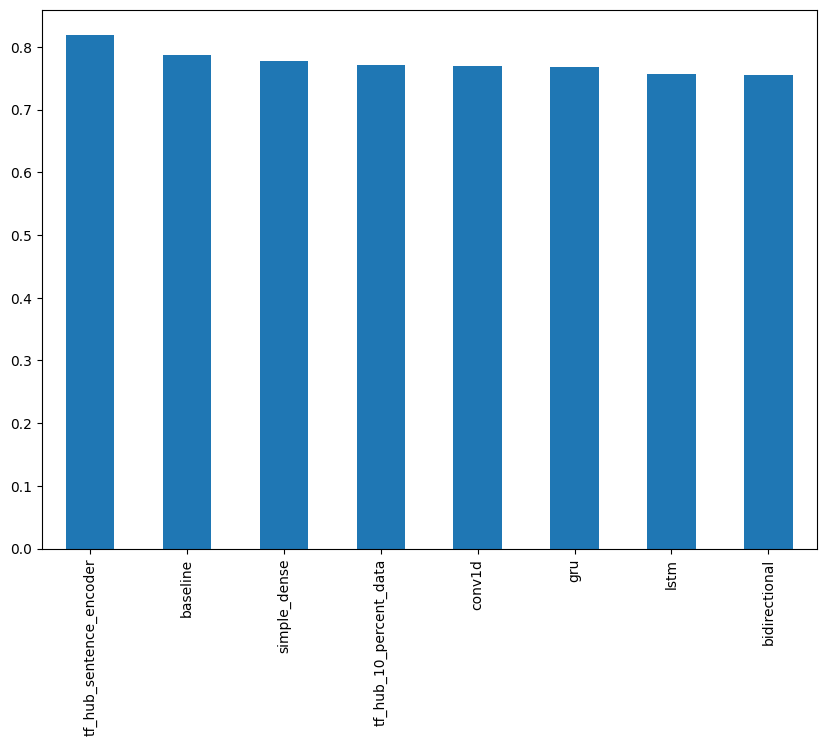

In [98]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Drilling down into a single metric we see our USE TensorFlow Hub models performing better than all of the other models. Interestingly, the baseline's F1-score isn't too far off the rest of the deeper models.

# Combining our models (model ensembling/stacking)

In many real-world applications, multiple models are combined to make a single, more reliable prediction — this approach is known as model ensembling.

The principle behind **model stacking** is simple:
if several different and independent models agree on a prediction, that prediction is generally more robust than one made by a single model.

The key word here is different (or uncorrelated) — meaning each model learns patterns in its own unique way.
For example, we could combine our Naive Bayes baseline, Bidirectional LSTM, and TensorFlow Hub USE models.
Even though they’re trained on the same dataset, each one processes and interprets the data differently.

If, instead, we used three very similar models — say, three LSTMs — they’d likely produce almost identical results, offering little benefit from combining them.

You can think of it like choosing a restaurant with friends:
if everyone with different tastes agrees on one place, it’s probably a great choice.

Since we’re tackling a classification problem, there are several effective ways we can combine our models’ outputs.

Here are the three main ways to combine model predictions in an ensemble:

	 •	Averaging – Take the predicted probabilities from each model for every sample, combine them, and compute their average. This smooths out individual model biases.

	 •	Majority Vote (Mode) – Each model predicts a class label for every sample, and the final prediction is the class chosen by the majority.
    For instance, if three models predict [1, 0, 1], the final output will be 1 since it’s the most common vote.

	 •	Model Stacking – Instead of directly combining predictions, feed the outputs from multiple models into another model (called a meta-model), which learns how to best weight and combine their results.

Again, the concept of model stacking is best seen in action.

**We're going to combine our baseline model (model_0), LSTM model (model_2) and our USE model trained on the full training data (model_6) by averaging the combined prediction probabilities of each.**

In [99]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Wonderful! We've got a combined predictions array of different classes, let's evaluate them against the true labels and add our stacked model's results to our all_model_results DataFrame.

In [100]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.13385826771653,
 'precision': 0.791149699877696,
 'recall': 0.7913385826771654,
 'f1': 0.7912098918900262}

In [101]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [102]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

/tmp/ipython-input-3504904892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


In [103]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.779528,0.782596,0.779528,0.777005
lstm,0.758530,0.759829,0.758530,0.756340
gru,0.770341,0.771589,0.770341,0.768449
bidirectional,0.757218,0.758599,0.757218,0.754947
conv1d,0.772966,0.777064,0.772966,0.769850
tf_hub_sentence_encoder,0.818898,0.819059,0.818898,0.818286
tf_hub_10_percent_data,0.774278,0.779922,0.774278,0.770623
ensemble_results,79.133858,0.791150,0.791339,0.791210


🔑 Note: It seems many of our model's results are similar. This may mean there are some limitations to what can be learned from our data. When many of your modelling experiments return similar results, it's a good idea to revisit your data, we'll do this shortly.

# Saving and loading a trained model

Even though training was relatively quick, it’s a good habit to save your trained models so you don’t need to retrain them later.

Saving your models also allows you to reuse or deploy them outside your notebook — for example, in a web or mobile application.

In TensorFlow, there are two primary ways [to save a model](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):


*   The HDF5 format.
*   The SavedModel format (default).

Let's take a look at both.

In [104]:
# Save TF Hub Sentence Encoder model to HDF5 format
save_model = "model_6.keras"
model_6.save(save_model)

In [105]:

# Load model previously saved above
#loaded_model_6 = tf.keras.models.load_model(save_model)

In [106]:
import tensorflow as tf
import tensorflow_hub as hub

loaded_model_6 = tf.keras.models.load_model(
    save_model,                      # e.g. "model_6.keras"
    custom_objects={"KerasLayer": hub.KerasLayer},
    compile=False
)

loaded_model_6.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    run_eagerly=True  # keep if you're using USE to avoid XLA issues
)

In [107]:
# How does our loaded model perform?
results_loaded_saved_model = loaded_model_6.evaluate(val_sentences, val_labels)
results_loaded_saved_model



24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5247 - loss: 0.6931


[0.6917926669120789, 0.5472440719604492]

🔍 Note:
After reloading the saved model, the evaluation accuracy does not perfectly match the original model’s accuracy. This discrepancy might be due to differences in TensorFlow/Keras serialization of custom layers (e.g., hub.KerasLayer) or optimizer states.
We will investigate this further later to ensure the model preserves its full performance after saving and loading.

# Finding the most wrong examples

If several models perform similarly, the issue might not be with the models but with the data itself.
A great way to explore this is by examining the samples where the model was most confident yet still made a wrong prediction — these “high-confidence errors” can reveal patterns or weaknesses in your dataset.

For a clearer analysis, we aggregate the model’s prediction probabilities, predicted labels, and corresponding validation samples (text and ground truth) into a unified pandas DataFrame, enabling structured visualization and error inspection.

*  If our best model still isn't perfect, what examples is it getting wrong?
*  Which ones are the most wrong?
*  Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [108]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.171248
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.814999
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.989945
3,@camilacabello97 Internally and externally scr...,1,0.0,0.206050
4,Radiation emergency #preparedness starts with ...,1,1.0,0.765945


Now let's find our model's wrong predictions (where target != pred) and sort them by their prediction probability (the pred_prob column).

In [109]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.920331
759,FedEx will no longer transport bioterror patho...,0,1.0,0.904826
628,@noah_anyname That's where the concentration c...,0,1.0,0.904321
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.883680
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.858165
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.850753
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.837380
474,My phone looks like it was in a car ship airpl...,0,1.0,0.836734
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.825767
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.814999


Finally, we can write some code to visualize the sample text, truth label, prediction class and prediction probability. Because we've sorted our samples by prediction probability, viewing samples from the head of our most_wrong DataFrame will show us false positives.

A reminder:

*  0 = Not a real diaster Tweet
*  1 = Real diaster Tweet

In [110]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9203310012817383
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9048263430595398
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.9043214917182922
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8836795091629028
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8581653833389282
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8507533073425293
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Pr

In [111]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06990230083465576
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.06190548464655876
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.061279866844415665
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05804833024740219
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.055255815386772156
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.04679816961288452
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.041825998

# Making predictions on the test dataset

Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [119]:
import tensorflow as tf
import random

# Run predictions safely on CPU to avoid XLA string op errors
with tf.device("/CPU:0"):
    test_sentences = test_df["text"].to_list()
    test_samples = random.sample(test_sentences, 10)

    for test_sample in test_samples:
        # Convert string to a tf.constant for compatibility
        input_text = tf.constant([test_sample], dtype=tf.string)

        # Run prediction (on CPU)
        pred_prob = tf.squeeze(model_6(input_text, training=False))
        pred = tf.round(pred_prob)

        print(f"Pred: {int(pred)}, Prob: {float(pred_prob):.4f}")
        print(f"Text:\n{test_sample}\n")
        print("----\n")

Pred: 1, Prob: 0.5012
Text:
AxWave enables a fast and accurate simulation of 2D and 3D seismic surveys in an acoustic medium #seismic #GPU #CPU http://t.co/OMX1NXAqpz

----

Pred: 0, Prob: 0.4988
Text:
@emmap645 @Vickygeex @Zak_Bagans @NickGroff_ @AaronGoodwin A few friends of mine were up investigatin the hellfire last year they had loads

----

Pred: 1, Prob: 0.5192
Text:
Survivors! Isabel Hodgins Danny Miller Laura Norton &amp; Mark Charnock take a group pic #SummerFate #BehindTheScenes https://t.co/qUKpVpwRFv

----

Pred: 0, Prob: 0.4881
Text:
New RAN report from the frontlines of human rights abuses and forest destruction for fashion.: http://t.co/OmpzUyAsle

----

Pred: 0, Prob: 0.4846
Text:
New US counter #terrorism program urges #Muslims to rat each other out critics say http://t.co/mVn6T9VhUl http://t.co/7lUfjX684i

----

Pred: 1, Prob: 0.5124
Text:
this is like when folks said ÛÏburning down buildings doesnÛªt workÛÛ_onlyÛ_it did. now cities trying to get information ou

# Predicting on Tweets from the wild

In [129]:
import tensorflow as tf

# Turn Tweet into string
Mo_tweet = "Life like an ensemble: take the best choices from others and make your own"

def predict_on_sentence(model, sentence):
    """
    Uses model to make a prediction on a sentence.

    Returns the sentence, the predicted label, and the prediction probability.
    """
    # Convert to a tf.constant (avoids Keras data adapter issues)
    input_text = tf.constant([sentence], dtype=tf.string)

    # Run the model directly on CPU to avoid XLA string op errors
    with tf.device("/CPU:0"):
        pred_prob = model(input_text, training=False)  # forward pass only

    pred_prob_value = float(pred_prob.numpy()[0][0])
    pred_label = int(round(pred_prob_value))
    label_text = "(real disaster)" if pred_label == 1 else "(not real disaster)"

    print(f"Pred: {pred_label} {label_text}, Prob: {pred_prob_value:.4f}")
    print(f"Text:\n{sentence}")

# 🔍 Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, sentence=Mo_tweet)

Pred: 0 (not real disaster), Prob: 0.4939
Text:
Life like an ensemble: take the best choices from others and make your own


Woohoo! Our model predicted correctly. My Tweet wasn't about a diaster.

How about we find a few Tweets about actual diasters?

Such as the following two Tweets about the 2020 Beirut explosions.

In [146]:
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

wildfire_tweet_2 = "Massive wildfire spreading near Los Angeles — residents urged to evacuate immediately."


In [144]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

Pred: 1 (real disaster), Prob: 0.5024
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [147]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

Pred: 1 (real disaster), Prob: 0.5197
Text:
Massive wildfire spreading near Los Angeles — residents urged to evacuate immediately.


Looks like our model is performing as expected, predicting both of the diaster Tweets as actual diasters.